In [1]:
import sys
sys.path.append("/home/mdzik/rysy/TCLB_tools/Python")


In [2]:
#!pip install --user display_xml ipywidgets

In [3]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from display_xml import XML
import CLB.CLBXMLWriter as CLBXML   
from CLB.JupyterHelper import MakeRunCase
import os

In [4]:
RunCase = MakeRunCase("singularity exec --bind /lu/tetyda/home/mdzik --nv /lu/tetyda/home/mdzik/rysy/TCLB_docker/.local/tclb_buildkit__ubuntu_2004_cuda11_latest mpirun -np 1 /lu/tetyda/home/mdzik/rysy/TCLB/CLB/auto_porous_media_d3q19_TRT_GinzburgEqOrd1/main")

# Poiseuille flow, no permability

In [55]:
# Prepare input


Viscosity = 1./6.
Length = 21
Gravity = 0.001

CLBc = CLBXML.CLBConfigWriter( )


CLBc.addGeomParam('nx', 6)
CLBc.addGeomParam('ny', Length)
CLBc.addGeomParam('nz', Length)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWall()
CLBc.addBox(dy=-1)
CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addRunR(eval=\
f"""
    Solver$Fields$InitialPorosity[] = 1;   
    Solver$Fields$Porosity[] = 1;   
    Solver$Fields$InitialPermability[] = 1E8
    Solver$Fields$Permability[] = 1E8
""")


CLBc.addHDF5()
time = 10000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('PouseiFlow.xml')


RunCase(os.getcwd()+'/PouseiFlow.xml')



0
1000
2000
3000
4000
5000
6000
7000
8000


<Figure size 432x288 with 0 Axes>

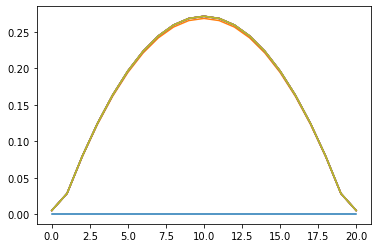

<Figure size 432x288 with 0 Axes>

In [56]:

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/PouseiFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,:,0,0])
    ut.append(np.absolute(f['U'][0,0,0,0]))

    
plt.figure()


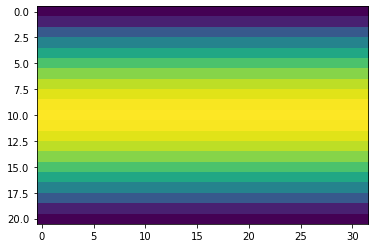

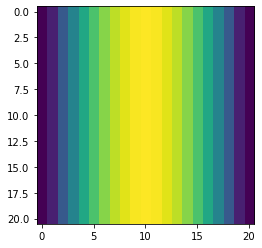

In [57]:
plt.imshow(f['U'][0,:,:,0])
plt.figure()
plt.imshow(f['U'][:,:,0,0])


# Poiseuille, inlet/outlet BC

0
1000
2000
3000
4000
5000
6000
7000
8000


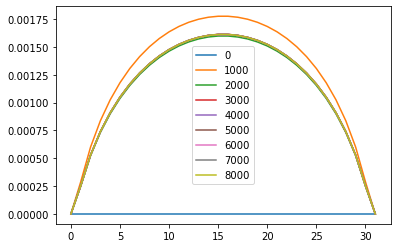

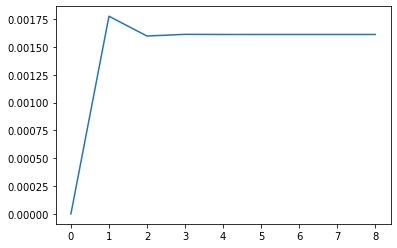

In [11]:
# Prepare input


Viscosity = 1./6.
Length = 32
Gravity = 0.000

CLBc = CLBXML.CLBConfigWriter( )


CLBc.addGeomParam('nx', 5*Length)
CLBc.addGeomParam('ny', Length)
CLBc.addGeomParam('nz', Length)


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()



CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)

CLBc.addWall()
CLBc.addBox(dx=-1)



CLBc.addWall()
CLBc.addBox(dy=-1)
CLBc.addBox(ny=1)
CLBc.addBox(dz=-1)
CLBc.addBox(nz=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addModelParam("Velocity", 0.1, zone='inlet')


CLBc.addRunR(eval=\
f"""
    Solver$Fields$InitialPorosity[] = 1;   
    Solver$Fields$Porosity[] = 1;   
    Solver$Fields$InitialPermability[] = 1E8
    Solver$Fields$Permability[] = 1E8
""")


CLBc.addHDF5()
time = 10000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('PouseiFlow.xml')


! rm -rf ./output/* 

RunCase(os.getcwd()+'/PouseiFlow.xml')



ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/PouseiFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,:,2*Length,0], label=i)
    ut.append(np.absolute(f['U'][0,int(Length/2),2*Length,0]))
plt.legend()
    
plt.figure()
plt.plot(ut)

#plt.imshow(f['U'][Length/2,:,:,0])

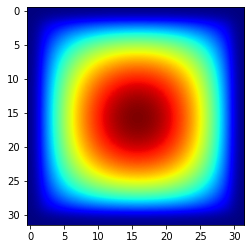

In [12]:
plt.imshow(f['U'][:,:,Length,0], interpolation='quadric', cmap='jet')

# Uniform permability, periodic domain

0
100
200
300
400
500
600
700
800


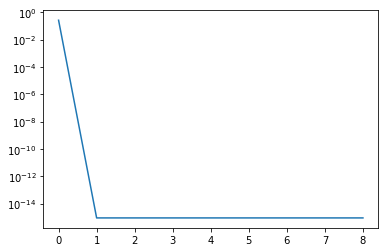

In [13]:
# Prepare input

UniformPermability = 0.03
Viscosity = 1./6.
Length = 32
Gravity = 0.001

Porosity = np.ones((Length,Length,Length)) 
Permability = np.ones_like(Porosity) * UniformPermability


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[1])
CLBc.addGeomParam('ny', dim[0])
CLBc.addGeomParam('nz', dim[2])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

# CLBc.addWDirichlet(name='inlet')
# CLBc.addBox(nx=1)

# CLBc.addENeuman()
# CLBc.addBox(dx=-2)
# CLBc.addWall()
# CLBc.addBox(dx=-1)
# CLBc.addBox(dy=-1)
# CLBc.addBox(ny=1)

params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 3./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)

CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*1})), c(2,{dim[0]},{dim[1]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 1000
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')
! rm -rf ./output/* 

RunCase(os.getcwd()+'/Pseudo1DFlow.xml')



ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    ut.append(np.absolute(f['U'][0,0,0,0] / (UniformPermability * Gravity / Viscosity) - 1))


plt.semilogy(ut)


# Non-uniform 1D permability assisted by linear pressure gradient

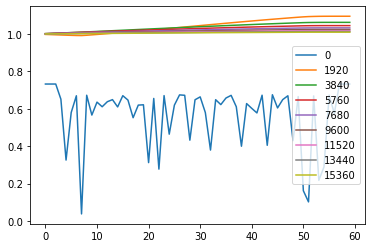

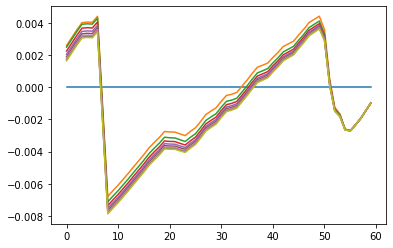

In [58]:
# Prepare input

Viscosity = 1./6.
Length = 64
Width = 32
Depth = 32
Velocity = 0.01

Permability = (np.random.rand(Length).reshape([Length,1,1])*1) + 0
Permability = np.repeat(np.repeat(Permability, Width,axis=1).T, Depth,axis=0)
Permability[:,:,:5] = 1E10
Permability[:,:,-5:] = 1E10

Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

Porosity = np.ones_like(Permability) 


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 1,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')

CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 3 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* 
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')


ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')   
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)


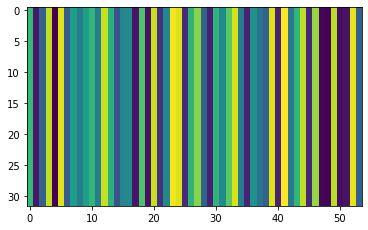

In [59]:
plt.imshow(f['Permability'][:,5,5:-5])

0
1920
3840
5760
7680
9600
11520
13440
15360
17280


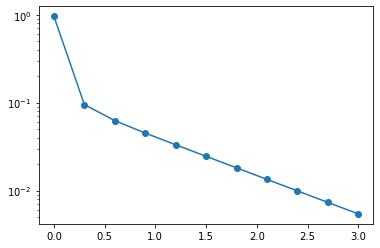

In [60]:
ut = list()
ts = list()
for i in range(0,time,int(time/10))[:]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    ut.append(np.max(np.absolute(f['U'][0,2:-2,2:-2,0]-Velocity))/Velocity)
    ts.append(i)
i = time

f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
ut.append(np.max(np.absolute(f['U'][0,2:-2,2:-2,0]-Velocity))/Velocity)
ts.append(i)
plt.semilogy(Velocity/Length*np.array(ts),ut, 'o-')

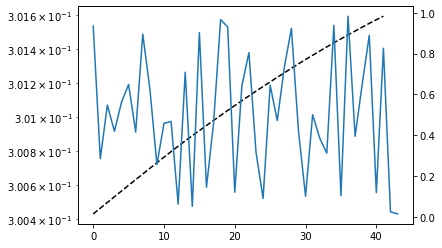

In [61]:
plt.semilogy(np.sum(f['U'][0,1:-1,1:-1,0], axis=0)[10:-10], 'k--')
plt.twinx()
plt.plot(f['Permability'][0,1,10:-10])

# Non-uniform 1D permability assisted by linear pressure gradient with concentration, without reaction

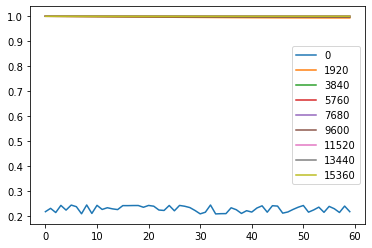

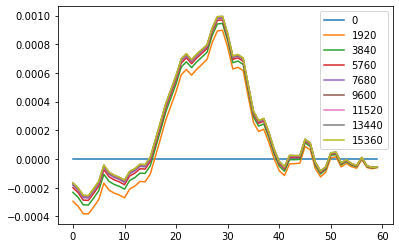

In [207]:
# Prepare input


Viscosity = 1./6.
Length = 64
Width = 32
Depth = 32
Velocity = 0.01

Permability = (np.random.rand(Length).reshape([Length,1,1])*0.2) + 0.2
Permability = np.repeat(np.repeat(Permability, Width,axis=1).T, Depth,axis=0)
#Permability[:,:,:5] = 1E10
#Permability[:,:,-5:] = 1E10

Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

Porosity = np.ones_like(Permability) 


#x = np.linspace(0,2*np.pi,Length)
#Permability = (np.sin(x)+1.1)*0.9
#Permability = np.ones((Width,Length)) * 1E6

#Permability[:,int(Length/3):int(2*Length/3)] = 0.1



init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)

#CLBc.addWall()
#CLBc.addBox(nx=2)
#CLBc.addBox(dx=-2, nx=1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": 0.0,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 1./6.,
        "Init_PHI": 0,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 1, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time =  3 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/* 
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')        
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()

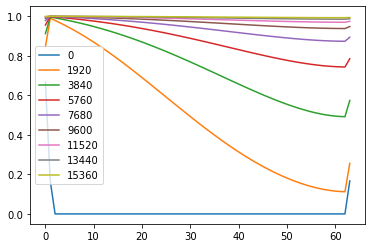

In [208]:
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['PHI'][5,5,:], '-' , label=i)
    
    
plt.legend()

# Non-uniform 1D permability assisted by linear pressure gradient with concentration, with linear reaction

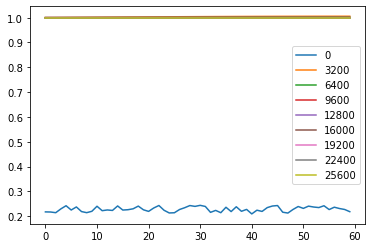

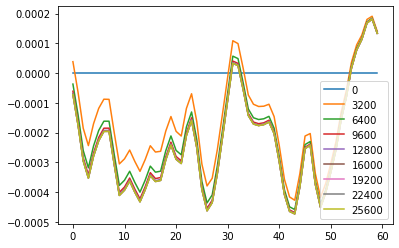

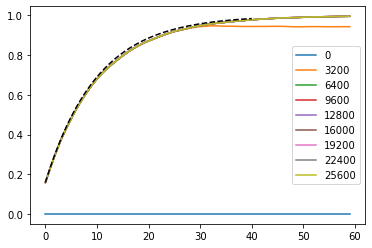

In [213]:
# Prepare input

LinearReactionRate = 0.001
Viscosity = 1./6.
Length = 64
Width = 32
Depth = 32
Velocity = 0.01

Permability = (np.random.rand(Length).reshape([Length,1,1])*0.2) + 0.2
Permability = np.repeat(np.repeat(Permability, Width,axis=1).T, Depth,axis=0)
#Permability[:,:,:5] = 1E10
#Permability[:,:,-5:] = 1E10

Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

Porosity = np.ones_like(Permability) 

Porosity = (np.random.rand(Length).reshape([Length,1,1])*0.4) + 0.2
Porosity = np.repeat(np.repeat(Porosity, Width,axis=1).T, Depth,axis=0)


init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 0,
        
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)
CLBc.addHDF5()

CLBc.write('Pseudo1DFlow.xml')


! rm -rf ./output/*
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')



ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')        
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()


plt.figure()


from scipy.integrate import odeint

def dydt(y,t,*gamma):
    return gamma[0]*(1-y)
   
y0 = f['PHI'][0,2,2]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['PHI'][0,2,2:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()

# Uniform 1D permability assisted by linear pressure gradient with concentration, with linear reaction and dissolituin

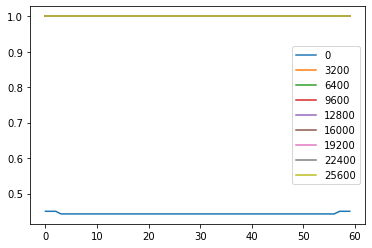

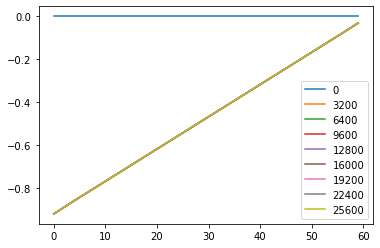

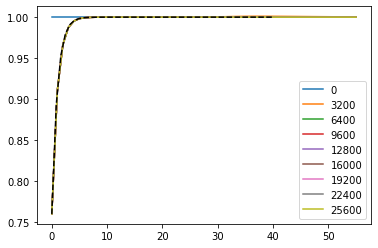

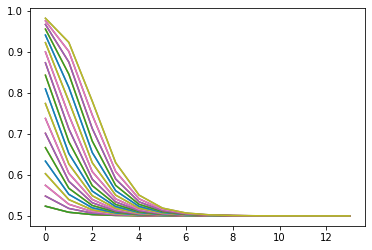

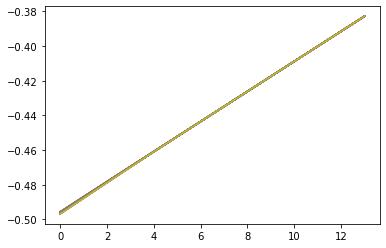

In [216]:
# Prepare input


Viscosity = 1./6.
Length = 64
Width = 32
Depth=32
Velocity = 0.01
LinearReactionRate = 0.01
KarmanKozenyCoefficient = 10
SolidFluidReactionRate = 10
Porosity = ((np.random.rand(Length).reshape([Length,1,1])-0.5)*0.) + 0.5
Porosity = np.repeat(np.repeat(Porosity, Width,axis=1).T, Depth,axis=0)



Porosity[:,:,:5] = 1
Porosity[:,:,-5:] = 1
Permability = KarmanKozenyCoefficient*Porosity**3/((1-Porosity)**2 + 1E-8)

Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 1D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": 0.001,
        "Init_PHI": 1,
        "ImpliciteReactionIntegration": 1,
        "KarmanKozenyCoefficient": KarmanKozenyCoefficient

}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")


CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)


CLBc.addModelParam("SolidFluidReactionsRate", SolidFluidReactionRate)
makroIterations = int(20)
time1 = makroIterations * 2 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time1)
CLBc.addHDF5(Iterations=time1/(makroIterations*2), parent=solve)
CLBc.addRunR(eval=\
f"""
    #Solver$Fields$InitialPorosity[] = Solver$Fields$Porosity[];    
    #Solver$Fields$InitialPermability[] = Solver$Fields$Permability[];
    Solver$Actions$GlobasPorosityDissolutionTimeStepAction()
""", Iterations = time1/makroIterations, parent=solve)



CLBc.write('Pseudo1DFlow.xml')



! rm -rf ./output/*
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')      
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
#plt.plot( np.ones(Length)*(np.average(Permability) * Gravity / Viscosity) , 'r--', lw=2    )
    
plt.figure()
#plt.semilogy(ut)
for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')       
    plt.plot(f['P'][0,2,2:-2] / (np.sum(1./Permability[0,:])*Velocity*Viscosity), label=i)
    
    
plt.legend()


plt.figure()


from scipy.integrate import odeint

def dydt(y,t,*gamma):
    return gamma[0]*(1-y)
   
y0 = f['PHI'][0,2,6]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')        
    plt.plot(f['PHI'][0,2,6:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()

plt.figure()
for i in time+np.arange(0,time1,int(time1/(makroIterations*2)))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['Porosity'][0,2,6:20], label=i)
    
plt.figure()
for i in time+np.arange(0,time1,int(time1/(makroIterations*2)))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    plt.plot(f['P'][0,2,6:20], label=i)    


# Non-uniform 2D permability assisted by linear pressure gradient with concentration, with linear reaction and dissolution

Pe = 32.0
Da = 327680.0


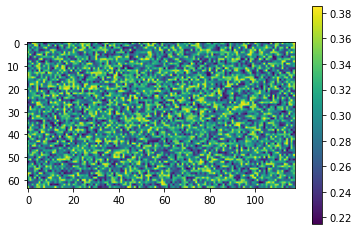

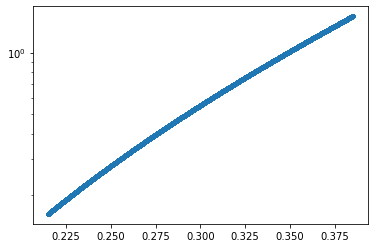

0.01001084449994839


In [5]:
# Prepare input

Viscosity = 1./6.
Length = 128
Width = 64
Depth=32
Velocity = 0.025
LinearReactionRate = 0.1
KarmanKozenyCoefficient = 10
SolidFluidReactionRate = 10
Diffusivity = 0.005

print(f'Pe = {Length*Velocity/LinearReactionRate}')
print(f'Da = {Length**2*LinearReactionRate/Diffusivity}')




Porosity = ((np.random.rand(Depth,Width,Length)-0.5)*0.17) + 0.3


Porosity[:,:,:5] = 1
Porosity[:,:,-5:] = 1
Permability = KarmanKozenyCoefficient*Porosity**3/((1-Porosity)**2 + 1E-8)

plt.imshow(Porosity[1,:,5:-5])
plt.colorbar()
plt.figure()
plt.semilogy(Porosity[:,:,5:-5].ravel(), Permability[:,:,5:-5].ravel(), '.')
plt.show()

Gravity = np.sum(1./Permability[0,0,:])*Velocity*Viscosity / (Length)

print(Gravity)
init_binfile = open('porosity.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Porosity,order='C'))
init_binfile.close()


init_binfile = open('permability.bin', 'wb')
#init_binfile.write(np.copy(permability.swapaxes(1,2),order='C'))
init_binfile.write(np.copy(Permability,order='C'))
init_binfile.close()

## Run 2D case


CLBc = CLBXML.CLBConfigWriter( )

dim = Permability.shape

CLBc.addGeomParam('nx', dim[2])
CLBc.addGeomParam('ny', dim[1])
CLBc.addGeomParam('nz', dim[0])


CLBc.addCollisionBlock(name='Collision')
CLBc.addBox()

CLBc.addWDirichlet(name='inlet')
CLBc.addBox(nx=1)

CLBc.addENeuman()
CLBc.addBox(dx=-1)


#CLBc.addWall()
#CLBc.addBox(nx=1)
#CLBc.addBox(dy=-1)
#CLBc.addBox(ny=1)


params = {
        "Viscosity":Viscosity,
        "ForceX":Gravity,
        "Magic": 4./8.,
        "LinearReactionRate": LinearReactionRate,
        "SolidFluidReactionsRate": 0,
        "Diffusivity_PHI": Diffusivity,
        "Init_PHI": 1,
        "ImpliciteReactionIntegration": 1,
        "KarmanKozenyCoefficient": KarmanKozenyCoefficient
}

CLBc.addModelParams(params)
CLBc.addModelParam("Velocity", Velocity, zone='inlet')
CLBc.addModelParam("Init_PHI", 0, zone='inlet')


CLBc.addRunR(eval=\
f"""
    con <- file("porosity.bin", "rb")
    Porosity <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)
    Solver$Fields$InitialPorosity[] = Porosity;   
    Solver$Fields$Porosity[] = Porosity;   
    
    con <- file("permability.bin", "rb")
    Permability <- matrix( readBin(con, "numeric", prod({dim[0]*dim[1]*dim[2]})), c({dim[2]},{dim[1]},{dim[0]}))
    close(con)    
    Solver$Fields$InitialPermability[] = Permability
    Solver$Fields$Permability[] = Permability
""")



CLBc.addHDF5()
time = 5 * int(Length/Velocity)
solve = CLBc.addSolve(iterations=time)
CLBc.addHDF5(Iterations=time/10, parent=solve)


CLBc.addModelParam("SolidFluidReactionsRate", SolidFluidReactionRate)
makroIterations = int(500)
time1 = makroIterations * int(Length/Velocity) / 2
solve = CLBc.addSolve(iterations=time1)
CLBc.addHDF5(Iterations=time1/(makroIterations), parent=solve)
CLBc.addRunR(eval=\
f"""
    #Solver$Fields$InitialPorosity[] = Solver$Fields$Porosity[];    
    #Solver$Fields$InitialPermability[] = Solver$Fields$Permability[];
    Solver$Actions$GlobasPorosityDissolutionTimeStepAction()
""", Iterations = time1/makroIterations, parent=solve)


CLBc.write('Pseudo1DFlow.xml')

! rm -rf ./output/*
RunCase(os.getcwd()+'/Pseudo1DFlow.xml')
#! rm -rf ./output/* && tclb auto_porous_media_d3q19_TRT_GinzburgEqOrd1 Pseudo1DFlow.xml > /dev/null && echo 'DONE'


0
2560
5120
7680
10240
12800
15360
17920
20480


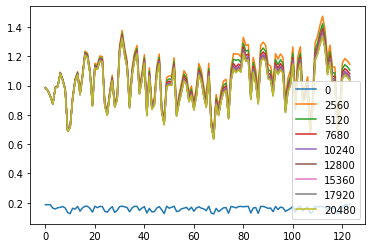

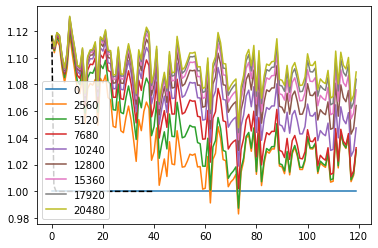

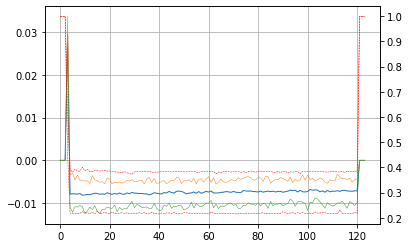

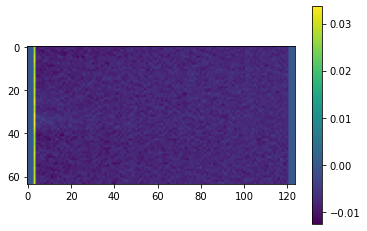

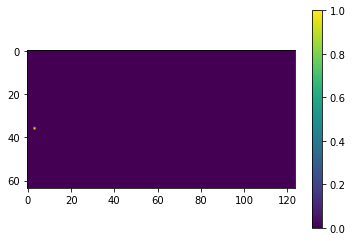

In [238]:

ut = list()
for i in range(0,time,int(time/10))[:-1]:
    print(i)
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    plt.plot(f['U'][0,2,2:-2,0]/Velocity, label=i)
    ut.append(np.absolute(f['U'][0,0,0,0]))
plt.legend()
    

plt.figure()
from scipy.integrate import odeint

def dydt(y,t,*gamma):
     return gamma[0]*(1-y)
   

y0 = f['PHI'][0,2,6]

t = np.linspace(0,40)
sol = odeint(dydt, y0, t, args=(LinearReactionRate/Velocity,0))


for i in range(0,time,int(time/10))[:-1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')        
    plt.plot(f['PHI'][0,2,6:-2], label=i)
    
plt.plot(t,sol, 'k--', lw=1.5)

plt.legend()


plt.figure()

plt.plot(f['ReactiveFlux'][0,:,2:-2].mean(axis=0), '-', lw=1)
plt.plot(f['ReactiveFlux'][0,:,2:-2].max(axis=0), '-', lw=0.5)
plt.plot(f['ReactiveFlux'][0,:,2:-2].min(axis=0), '-', lw=0.5)

plt.grid()
plt.twinx()
plt.plot(f['Porosity'][0,:,2:-2].min(axis=0), 'r--', lw=0.5)
plt.plot(f['Porosity'][0,:,2:-2].max(axis=0), 'r--', lw=0.5)

plt.figure()

plt.imshow(f['ReactiveFlux'][0,:,2:-2] )
plt.colorbar()

plt.figure()
C = 4*Porosity[0,:,2:-2]*(1-Porosity[0,:,2:-2])*LinearReactionRate*(1 - f['PHI'][0,:,2:-2]);
plt.imshow(C*SolidFluidReactionRate > Porosity[0,:,2:-2])
plt.colorbar()

<ipython-input-239-1631b728273f>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)


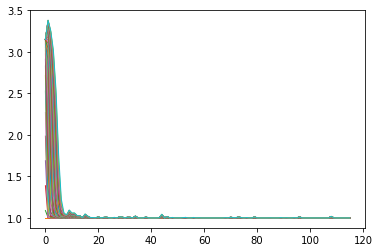

In [239]:
plt.figure()
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[:]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    #plt.plot(f['Porosity'][0,:,6:-6].min(axis=0), '--', lw=0.5)
    #plt.plot(f['Porosity'][0,:,6:-6].max(axis=0), '--', lw=0.5)
    plt.plot((f['Porosity'][0,:,6:-6]/f0['Porosity'][0,:,6:-6]).mean(axis=0), '-', lw=1)

<ipython-input-240-716d5ef2dc0c>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)


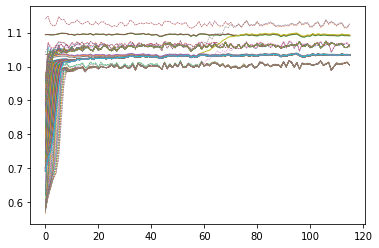

In [240]:
plt.figure()
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::1]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')   
    
    rp = f['PHI'][0,:,6:-6] 
    
    plt.plot(rp.min(axis=0), '--', lw=0.5)
    plt.plot(rp.max(axis=0), '--', lw=0.5)
    plt.plot(rp.mean(axis=0), '-', lw=1)

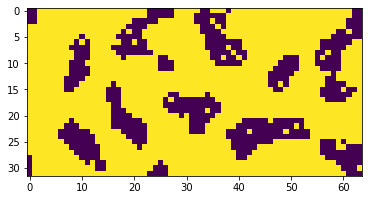

In [244]:
plt.imshow(f['Porosity'][:,:,10]/f0['Porosity'][:,:,10] > 1.1)

<ipython-input-245-da3c83d56546>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)


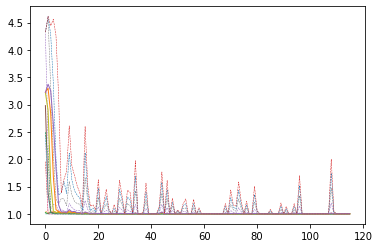

In [245]:
plt.figure()
i = 0
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::10]:
    f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
    
    rp = f['Porosity'][0,:,6:-6]/f0['Porosity'][0,:,6:-6]
    
    plt.plot(rp.min(axis=0), '--', lw=0.5)
    plt.plot(rp.max(axis=0), '--', lw=0.5)
    plt.plot(rp.mean(axis=0), '-', lw=1)

<ipython-input-246-558579a7d7e2>:3: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)
<ipython-input-246-558579a7d7e2>:14: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%ik)


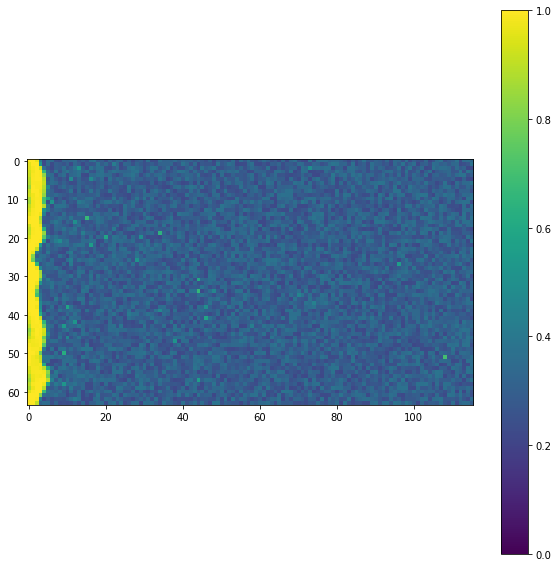

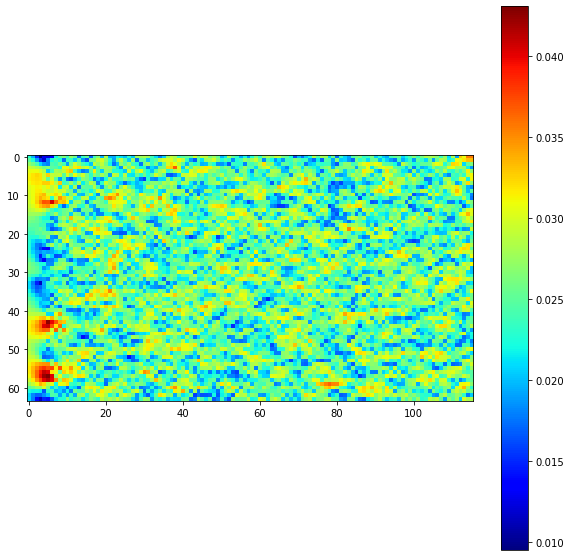

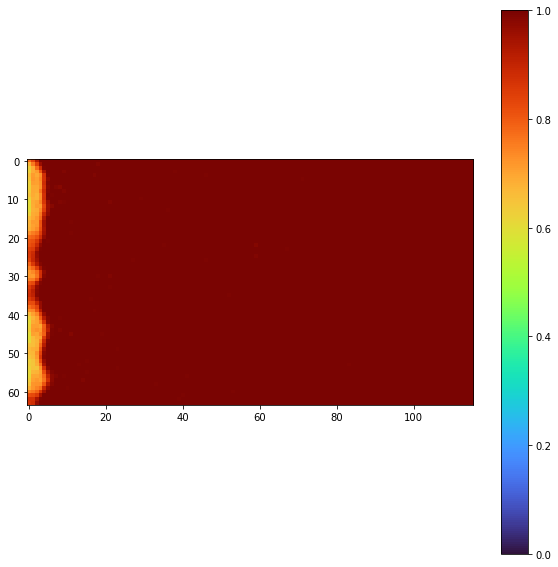

128000.0


In [246]:
plt.figure(figsize=(10,10))
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  
ii = 1
try:
    for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::10]:
        f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')    
        if np.any(np.isnan(f['Porosity'][0,:,6:-6])): 
            raise Exception()
        ik = i
            
except:
    pass
f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%ik)            
df = f['Porosity'][0,:,6:-6]#/f0['Porosity'][0,:,6:-6] 
plt.imshow(df,interpolation='none')
plt.clim(0,1)
plt.colorbar()
ii = ii + 1


plt.figure(figsize=(10,10))
df = np.sqrt(f['U'][1,:,6:-6,0]**2 + f['U'][1,:,6:-6,1]**2)
plt.imshow(df,interpolation='none',cmap='jet')
#plt.clim(0,1)
plt.colorbar()
ii = ii + 1


plt.figure(figsize=(10,10))
df = f['PHI'][1,:,6:-6]
plt.imshow(df,cmap='turbo')
plt.clim(0,1)
plt.colorbar()
ii = ii + 1

#plt.savefig(r'./movie/wormhole-%03d.png'%ii, dpi=100)
plt.show()    
print(ik)

<ipython-input-248-99a91b62c3b0>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)
<ipython-input-248-99a91b62c3b0>:15: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%ik)


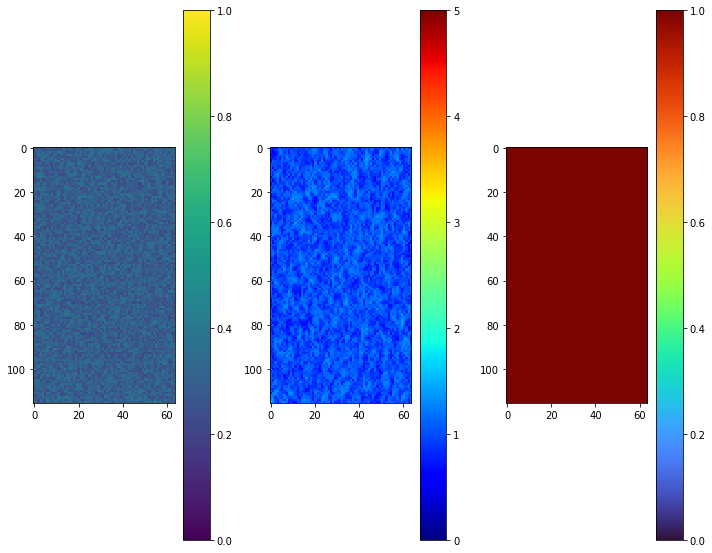

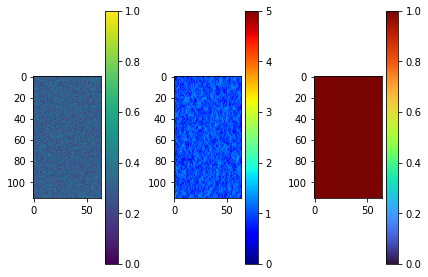

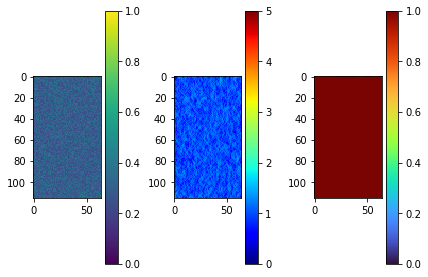

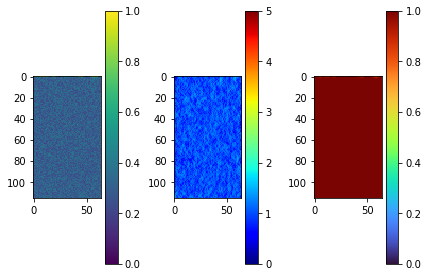

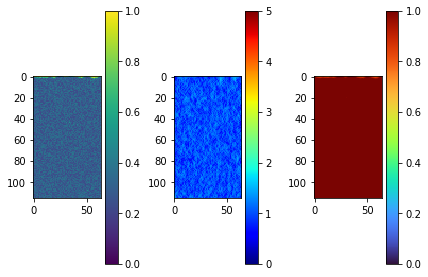

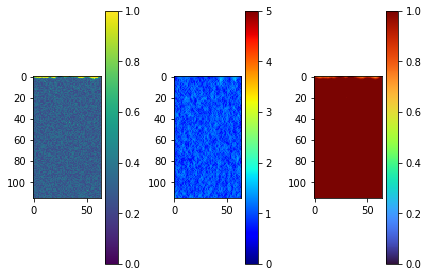

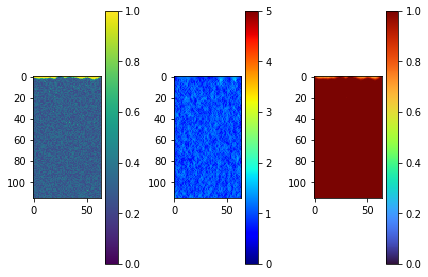

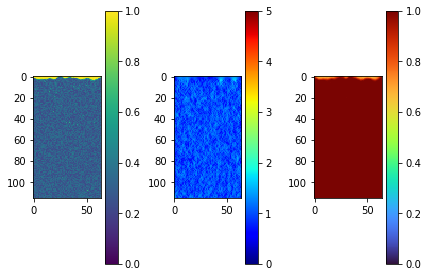

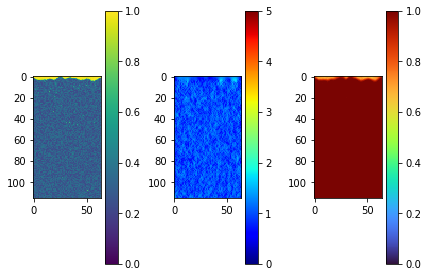

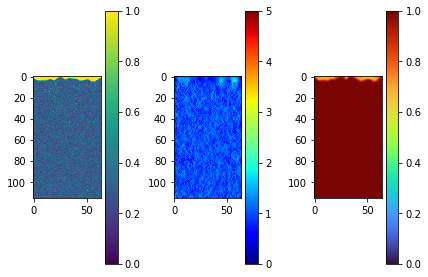

<Figure size 432x288 with 0 Axes>

In [248]:
i = time
f0 = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i)  
ii = 1
plt.figure(figsize=(10,10))

try:
    for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::5]:
        f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%i,mode='r')        
        if np.any(np.isnan(f['Porosity'][0,:,6:-6])): 
            raise Exception()
        ik = i
            
    
        plt.subplot(131)
        f = h5py.File('./output/Pseudo1DFlow_HDF5_%08d.h5'%ik)            
        df = f['Porosity'][0,:,6:-6]#/f0['Porosity'][0,:,6:-6] 
        plt.imshow(df.T,interpolation='none')
        plt.clim(0,1)
        plt.colorbar()


        plt.subplot(132)
        df = np.sqrt(f['U'][1,:,6:-6,0]**2 + f['U'][1,:,6:-6,1]**2) / Velocity
        plt.imshow(df.T,interpolation='none',cmap='jet')
        plt.clim(0,5)
        plt.colorbar()


        plt.subplot(133)
        df = f['PHI'][1,:,6:-6]
        plt.imshow(df.T,cmap='turbo')
        plt.clim(0,1)
        plt.colorbar()
        ii = ii + 1
        plt.tight_layout()
        plt.savefig(r'./movie/wormhole-%04d.png'%ii, dpi=100)
        plt.show()
        plt.clf()
except:
    pass
        

In [6]:
i = time
f0 = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')  
ii = 1
plt.figure(figsize=(10,10))
Porosity_Evelotion = list()

for i in time+np.arange(0,time1,int(time1/(makroIterations)))[::5]:
    print(i)
    f = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%i, mode='r')    
    if np.any(np.isnan(f['Porosity'][0,:,6:-6])): 
        raise Exception()
    ik = i           

    f = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%ik)            
    Porosity_Evelotion.append((np.sum(f['Porosity'][0,:,:])))



25600.0


<ipython-input-6-4234822b1d6f>:14: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File('./output_1/Pseudo1DFlow_HDF5_%08d.h5'%ik)


38400.0
51200.0
64000.0
76800.0
89600.0
102400.0
115200.0
128000.0
140800.0
153600.0
166400.0
179200.0
192000.0
204800.0
217600.0
230400.0
243200.0
256000.0
268800.0
281600.0
294400.0
307200.0
320000.0
332800.0
345600.0
358400.0
371200.0
384000.0
396800.0
409600.0
422400.0
435200.0
448000.0
460800.0
473600.0
486400.0
499200.0
512000.0
524800.0
537600.0
550400.0
563200.0
576000.0
588800.0
601600.0
614400.0
627200.0
640000.0
652800.0
665600.0
678400.0
691200.0
704000.0
716800.0
729600.0
742400.0
755200.0
768000.0
780800.0
793600.0
806400.0
819200.0
832000.0
844800.0
857600.0
870400.0
883200.0
896000.0
908800.0
921600.0
934400.0
947200.0
960000.0
972800.0
985600.0
998400.0
1011200.0
1024000.0
1036800.0
1049600.0
1062400.0
1075200.0
1088000.0
1100800.0
1113600.0
1126400.0
1139200.0
1152000.0
1164800.0
1177600.0
1190400.0
1203200.0
1216000.0
1228800.0
1241600.0
1254400.0
1267200.0
1280000.0
1292800.0


<Figure size 720x720 with 0 Axes>

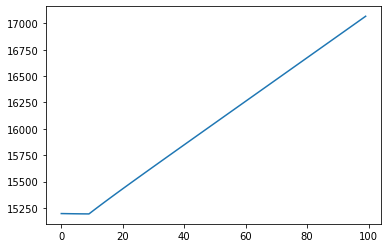

In [7]:
plt.plot(Porosity_Evelotion, '-')